In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys
import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
# Classification
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Selection
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import f1_score, log_loss, matthews_corrcoef

# Visualization
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

## Data Preprocessing

First, basic data preprocessing to obtain accepted and rejected training and test samples separately. Save rejected data in two versions: with and without lables. The rejected data without labels is needed for the semi-supervised model. The rejected data without labels is needed to perform evaluation. 

In [3]:
def data_preprocessing(df, accepted_flag, target, train_ratio):
    """
    The goal of this function is to load the original dataset, split it into accepts and rejects,
    add ids, which can later be used for merging. For the rejects to further perform train / test split

    Parameters
    ----------

    df : name of the original dataset in quotation marks, csv format
    accepted_flag: name of the accepted flag; Binary: 1 if accepted, 0 if rejected
    target : name of the target column
    train_ratio : percentage used for training; Continuous (0,1)

    Return
    ------
    a : accepted data
    r : rejected data
    r_dev : rejected trainining data without label
    r_test : rejected testing data without label
    dfr_dev_with_label: rejected training data with label
    dft_test_with_label: rejected training data with label

    """
    # Load data
    data = pd.read_csv("C:/Users/Asus/Desktop/Repo/MasterThesis_RI/Data_09_05/" + df)

    # Accepted

    ## Create separate dataset with accepts
    dfa = data[data[accepted_flag] == 1]
    dfa = dfa.drop([accepted_flag], axis=1)
    ## Rename target variable as "target"
    dfa = dfa.rename(columns={target: "target"})
    ## Add id to the dataset, which can later be used for merging
    # dfa["id"] = dfa.index.to_series().map(lambda x: uuid.uuid4())

    # Rejected

    ## Create separate dataset with accepts
    dfr = data[data[accepted_flag] == 0]
    dfr = dfr.drop([accepted_flag], axis=1)
    ## Add id to the dataset, which can later be used for merging
    #     dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())
    ## Train/Test Split (without labels)
    ### Shuffle the dataset
    shuffle_df = dfr.sample(frac=1, random_state=42)
    ### Define a size for the train set
    train_size = int(train_ratio * len(shuffle_df))
    ### Split the dataset
    dfr_dev = shuffle_df[:train_size]
    dfr_test = shuffle_df[train_size:]
    ## Save a copy of the rejected data with label
    dfr_dev_with_label = dfr_dev
    dfr_test_with_label = dfr_test
    ## Unlabel the rejects (i.e. drop the target) and save a copy of the rejeted data without label
    dfr_dev2 = dfr_dev_with_label.drop([target], axis=1)
    dfr_test2 = dfr_test_with_label.drop([target], axis=1)
    # Rename target variable
    dfr_dev_with_label = dfr_dev_with_label.rename(columns={target: "target"})
    dfr_test_with_label = dfr_test_with_label.rename(columns={target: "target"})

    return dfr_dev_with_label, dfr_test_with_label, dfa, dfr, dfr_dev2, dfr_test2

<IPython.core.display.Javascript object>

In [4]:
dfr_dev_with_label, dfr_test_with_label, a, r, r_dev, r_test = data_preprocessing(
    "cons_scen4_1.csv", "is_accepted", "y", 0.8
)

<IPython.core.display.Javascript object>

The below two functions continue the data preprocessing. Used to create feature and target data and to split into train and test samples.

In [5]:
def create_X_y(data):
    """
    Undersample the data

    Parameters
    ----------
    data : Dataframe

    Return
    ------
    X_res : undersampled data; Dataframe
    y_res : undersampled labels; Dataframe

    """
    # Create X and y
    X = data.loc[:, data.columns != "target"]
    y = data.loc[:, data.columns == "target"]

    return X, y

<IPython.core.display.Javascript object>

In [6]:
def split(X, y):
    """
    Split the data into training and testing sample

    Parameters
    ----------
    X : data
    y : labels

    Return
    ------
    X_train : training modelling fields
    X_test : test modelling fields
    y_train : training labels
    y_test : testing labels

    """
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=7
    )
    columns = X_train.columns

    # Columns
    X_train = pd.DataFrame(data=X_train, columns=columns)
    y_train = pd.DataFrame(data=y_train, columns=["target"])

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

In [7]:
X_res, y_res = create_X_y(a)
X_train, X_test, y_train, y_test = split(X_res, y_res)
dfr_test_with_label_X = dfr_test_with_label.loc[:, dfr_test_with_label.columns != "y"]
dfr_test_with_label_y = dfr_test_with_label.loc[:, dfr_test_with_label.columns == "y"]

<IPython.core.display.Javascript object>

## Feature Selection

First, we select the features that will end up in the model. The selection of columns below is subject to iteration based on the modelling outcomes from the logistic regression, i.e. significance (p-values).

In [8]:
significant_columns = [
    # "known_col_0",
    "known_col_1",
    "known_col_3",
    "known_col_4",
]

<IPython.core.display.Javascript object>

In [9]:
X_train2 = X_train.copy()
y_train2 = y_train.copy()
X_test2 = X_test.copy()
y_test2 = y_test.copy()
r_dev2 = r_dev.copy()
r_test2 = r_test.copy()

<IPython.core.display.Javascript object>

In [10]:
# Primary datasets
X_train = X_train[significant_columns]
X_test = X_test[significant_columns]
r_dev = r_dev[significant_columns]
r_test = r_test[significant_columns]

<IPython.core.display.Javascript object>

In [11]:
# Build Logistic regression
# Statmodels
X_in = sm.add_constant(X_train.astype(float))
logit_model = sm.Logit(y_train, X_in)
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.080708
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.720    
Dependent Variable: target           AIC:              2074.1157
Date:               2021-05-23 21:31 BIC:              2103.9445
No. Observations:   12800            Log-Likelihood:   -1033.1  
Df Model:           3                LL-Null:          -3684.3  
Df Residuals:       12796            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     11.0000                                     
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
const           -8.2442   0.2502 -32.9530 0.0000 -8.7346 -7.7539
known_col_1      5.5122   0.1784  30.8953 0.0000  5.1625  5.8619
known_col_3 

<IPython.core.display.Javascript object>

In [12]:
# Calculate Default Rates
dr = len(y_test[y_test["target"] == 1]) / (
    len(y_test[y_test["target"] == 1]) + len(y_test[y_test["target"] == 0])
)
conservative_dr = (
    1.1
    * len(y_test[y_test["target"] == 1])
    / (len(y_test[y_test["target"] == 1]) + len(y_test[y_test["target"] == 0]))
)

<IPython.core.display.Javascript object>

## Isolation Forest

For rejects, another step of data preporcessing is applied via Isolation Forest model. The goal is to remove outliers. The isolation forest is trained on all accepts and is used to evaluate the similarity of the rejects. Then the rejects that are found to be the most and least similar to the accepts are dropped. The contaimination parameter determines how many observations are excluded.

In [13]:
# def isolation_forest(X_train, r_dev, r_test):
#     """
#     The goal of this function is to filter the outliers from the rejected sample.

#     Parameters
#     ----------
#     X_train: accepts training data; Dataframe
#     r_dev_mod: rejects modelling data prior outlier treatment; Dataframe
#     r_test_mod: rejects testinf data prior outlier treatment; Dataframe

#     Return
#     ------
#     r_dev_mod: rejects modelling data post outlier treatment; Dataframe
#     r_test_mod: rejects training data prior outlier treatment; Dataframe

#     """

#     # Build Isolation forest model
#     isf = IsolationForest(
#         n_estimators=50,
#         max_samples="auto",
#         contamination=float(0.005),
#         max_features=1.0,
#     )
#     isf.fit(X_train)
#     rej_isf = isf.predict(r_dev)
#     # Add scores and anomaly columns to rejected train
#     r_dev["scores"] = isf.decision_function(r_dev)
#     r_dev["anomaly"] = isf.predict(r_dev[significant_columns])
#     # Print number of non-outliers and outliers
#     print("Rejected Train. Number of non-outliers is:", np.sum(r_dev["anomaly"] == 1))
#     print("Rejected Train. Number of outliers is:", np.sum(r_dev["anomaly"] == -1))
#     # Drop all outliers
#     r_dev = r_dev[r_dev.anomaly != -1]
#     # Delete columns related to the outliers
#     r_dev = r_dev[significant_columns]

#     # Add scores and anomaly columns to rejected test
#     r_test["scores"] = isf.decision_function(r_test)
#     r_test["anomaly"] = isf.predict(r_test[significant_columns])
#     # Print number of non-outliers and outliers
#     print("Rejected Test. Number of non-outliers is:", np.sum(r_test["anomaly"] == 1))
#     print("Rejected Test. Number of outliers is:", np.sum(r_test["anomaly"] == -1))
#     # Drop all outliers
#     r_test = r_test[r_test.anomaly != -1]
#     # Delete columns related to the outliers
#     r_test = r_test[significant_columns]

#     return r_dev, r_test

<IPython.core.display.Javascript object>

In [14]:
# r_dev, r_test = isolation_forest(X_train, r_dev, r_test)

<IPython.core.display.Javascript object>

## Self Training for the Most Certain examples with Max F1 score as stopping criteria

In [15]:
# Create copies of the data that can be overwritten in the function below
X_train_iter = X_train.copy()
y_train_iter = y_train.copy()
r_dev_iter = r_dev.copy()

<IPython.core.display.Javascript object>

In [16]:
# f1_scores = []
# iterations = []
# # log_losses = []

# for iteration in range(1, 25):  # Change to how many iterrations you like
#     print("Iteration Nr {}".format(iteration))
#     # Build logistic regression
#     #     KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
#     #         X_train_iter, y_train_iter
#     #     )
#     # KGB1 = RandomForestClassifier().fit(X_train_iter, y_train_iter)

#     # Active Learning
#     n_initial = len(X_train_iter)
#     initial_idx = np.random.choice(
#         range(len(X_train_iter)), size=n_initial, replace=False
#     )
#     X_training, y_training = (
#         X_train_iter.iloc[initial_idx],
#         y_train_iter.iloc[initial_idx],
#     )

#     KGB1 = ActiveLearner(
#         estimator=LogisticRegression(fit_intercept=False, penalty="none").fit(
#             X_train_iter, y_train_iter
#         ),
#         query_strategy=uncertainty_sampling,
#         X_training=X_training,
#         y_training=y_training,
#     )
#     query_idx, query_inst = KGB1.query(X_training)
#     # active learning
#     for idx in range(5):
#         query_idx, query_instance = KGB1.query(X_train_iter)
#         KGB1.teach(X_train_iter.iloc[query_idx], y_train.iloc[query_idx])

#     f1_stat = f1_score(KGB1.predict(X_test), y_test, average="weighted")
#     f1_scores.append(f1_stat)
#     print("F1: ", f1_stat)

#     #     logloss = log_loss(KGB1.predict(X_test), y_test, eps=1e-15)
#     #     log_losses.append(log_losses)
#     # print("Log Loss: ", logloss)
#     # Make predictions on the rejected data
#     pred = KGB1.predict_proba(r_dev_iter)[:, 1]
#     pred = pd.DataFrame(
#         data=pred,
#         columns=["target"],
#         index=r_dev_iter.index.copy(),
#     )

#     # Choose the most certain predictions
#     lq = pred["target"].quantile(q=0.05)
#     uq = pred["target"].quantile(q=0.95)
#     pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

#     # If PD is high, apply default status
#     pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

#     # Pick only the certain predictions and concatenate them to the dev set
#     # Y TRAIN
#     certain = pred[pred["certain"] == 1]
#     certain2 = certain["target"].to_frame()
#     y_train_iter = pd.concat((y_train_iter, certain2))

#     # Get significant columns of the rejects based on index
#     certain_features = pd.merge(
#         certain["target"],
#         r_dev_iter[significant_columns],
#         how="inner",
#         left_index=True,
#         right_index=True,
#     )

#     # X TRAIN
#     certain_features = certain_features.loc[:, certain_features.columns != "target"]
#     X_train_iter = pd.concat((X_train_iter, certain_features))

#     # Remove certain columns from rejected data
#     rows = certain_features.index
#     r_dev_iter = r_dev_iter.drop(rows, axis="index")

<IPython.core.display.Javascript object>

In [17]:
f1_scores = []
log_losses = []
mccs = []
iterations = []

for iteration in range(1, 25):
    print("Iteration Nr {}".format(iteration))
    # Build logistic regression
    KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
        X_train_iter, y_train_iter
    )
    # KGB1 = RandomForestClassifier().fit(X_train_iter, y_train_iter)

    # Scores
    #     f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
    #     f1_scores.append(f1_stat)

    #     logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
    #     log_losses.append(logloss)

    mcc = matthews_corrcoef(y_test, KGB1.predict(X_test))
    mccs.append(mcc)

    print("MCC: ", mcc)

    # Make predictions on the rejected data
    pred = KGB1.predict_proba(r_dev_iter)[:, 1]
    pred = pd.DataFrame(
        data=pred,
        columns=["target"],
        index=r_dev_iter.index.copy(),
    )

    # Choose the most certain predictions
    lq = pred["target"].quantile(q=0.05)
    uq = pred["target"].quantile(q=0.95)
    pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

    # If PD is high, apply default status
    pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

    # Pick only the certain predictions and concatenate them to the dev set
    # Y TRAIN
    certain = pred[pred["certain"] == 1]
    certain2 = certain["target"].to_frame()
    y_train_iter = pd.concat((y_train_iter, certain2))

    # Get significant columns of the rejects based on index
    certain_features = pd.merge(
        certain["target"],
        r_dev_iter[significant_columns],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # X TRAIN
    certain_features = certain_features.loc[:, certain_features.columns != "target"]
    X_train_iter = pd.concat((X_train_iter, certain_features))

    # Remove certain columns from rejected data
    rows = certain_features.index
    r_dev_iter = r_dev_iter.drop(rows, axis="index")

Iteration Nr 1
MCC:  0.3163564161895653
Iteration Nr 2
MCC:  0.33494179519768463
Iteration Nr 3
MCC:  0.34478303312148695
Iteration Nr 4
MCC:  0.3563297917229042
Iteration Nr 5
MCC:  0.3603054839723956
Iteration Nr 6
MCC:  0.3615797460033729
Iteration Nr 7
MCC:  0.360848457356094
Iteration Nr 8
MCC:  0.3596341940122227
Iteration Nr 9
MCC:  0.36498499456095573
Iteration Nr 10
MCC:  0.3651627525044242
Iteration Nr 11
MCC:  0.3632495735350181
Iteration Nr 12
MCC:  0.36158702909575424
Iteration Nr 13
MCC:  0.3601704011538562
Iteration Nr 14
MCC:  0.3587614353620926
Iteration Nr 15
MCC:  0.3580597962777427
Iteration Nr 16
MCC:  0.3575930822285857
Iteration Nr 17
MCC:  0.3573600375196327
Iteration Nr 18
MCC:  0.3573600375196327
Iteration Nr 19
MCC:  0.3561979200987489
Iteration Nr 20
MCC:  0.3555031193239494
Iteration Nr 21
MCC:  0.35596611487585106
Iteration Nr 22
MCC:  0.3548101569612283
Iteration Nr 23
MCC:  0.35411902178264953
Iteration Nr 24
MCC:  0.35411902178264953


<IPython.core.display.Javascript object>

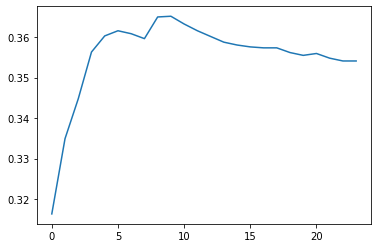

<IPython.core.display.Javascript object>

In [18]:
plt.plot(mccs, label="MCCs")

In [19]:
# Save the iteration of the model where max MCC score is reached
max_value = max(mccs)
max_index = mccs.index(max_value)
print(max_index)

9


<IPython.core.display.Javascript object>

### Do only 1 iteration as baseline Model

In [20]:
# Create copies of the data that can be overwritten in the function below
X_train_iter1 = X_train.copy()
y_train_iter1 = y_train.copy()
r_dev_iter1 = r_dev.copy()

<IPython.core.display.Javascript object>

In [21]:
# Add more scores that you want to track
f1_scores = []
mccs = []
iterations = []
# log_losses = []

for iteration in range(1, 2):  # Change to how many iterrations you like
    print("Iteration Nr {}".format(iteration))
    # Build logistic regression
    KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
        X_train_iter1, y_train_iter1
    )
    # KGB1 = RandomForestClassifier().fit(X_train_iter1, y_train_iter1)

    # Scores
    #     f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
    #     f1_scores.append(f1_stat)
    #     print("F1: ", f1_stat)

    #     logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
    #     log_losses.append(logloss)

    mcc = matthews_corrcoef(y_test, KGB1.predict(X_test))
    mccs.append(mcc)

    print("MCC: ", mcc)

    # Make predictions on the rejected data
    pred = KGB1.predict_proba(r_dev_iter1)[:, 1]
    pred = pd.DataFrame(
        data=pred,
        columns=["target"],
        index=r_dev_iter1.index.copy(),
    )

    # Choose the most certain predictions
    lq = pred["target"].quantile(q=0.05)
    uq = pred["target"].quantile(q=0.95)
    pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

    # If PD is high, apply default status
    pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

    # Pick only the certain predictions and concatenate them to the dev set
    # Y TRAIN
    certain = pred[pred["certain"] == 1]
    certain2 = certain["target"].to_frame()
    y_train_iter1 = pd.concat((y_train_iter1, certain2))

    # Get significant columns of the rejects based on index
    certain_features = pd.merge(
        certain["target"],
        r_dev_iter1[significant_columns],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # X TRAIN
    certain_features = certain_features.loc[:, certain_features.columns != "target"]
    X_train_iter1 = pd.concat((X_train_iter1, certain_features))

    # Remove certain columns from rejected data
    rows = certain_features.index
    r_dev_iter1 = r_dev_iter1.drop(rows, axis="index")

Iteration Nr 1
MCC:  0.3163564161895653


<IPython.core.display.Javascript object>

In [22]:
def predict_rejects(model, r_dev):
    # Make predictions on the Train Rejects
    pred_test = model.predict_proba(r_dev)[:, 1]
    pred_test = pd.DataFrame(
        data=pred_test,
        columns=["pred"],
        index=r_dev.index.copy(),
    )

    # Make binary predictions based on cutoff DR
    q1 = pred_test["pred"].quantile(q=1 - conservative_dr)
    pred_test["target"] = pred_test["pred"].apply(lambda x: 0 if (x < q1) else 1)
    pred_test = pred_test["target"].to_frame()

    # Add new rows to df
    y_train_new = pd.concat((y_train, pred_test))
    X_train_new = pd.concat((X_train, r_dev))

    # Fit new model
    KGB_baseline_new = LogisticRegression(fit_intercept=False, penalty="none").fit(
        X_train_new, y_train_new
    )
    #     KGB_baseline_new = RandomForestClassifier().fit(X_train_new, y_train_new)
    return KGB_baseline_new

<IPython.core.display.Javascript object>

In [23]:
def evaluate_test_accepts(model, X_test):
    pred_test = model.predict_proba(X_test)[:, 1]
    pred_test = pd.DataFrame(
        data=pred_test,
        columns=["pred"],
        index=X_test.index.copy(),
    )

    # Merge with Target
    pred_test2 = pd.merge(
        pred_test["pred"],
        y_test["target"],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff 50percentile of the distribution
    q1 = pred_test2["pred"].quantile(q=1 - conservative_dr)
    pred_test2["prediction_baseline"] = pred_test2["pred"].apply(
        lambda x: 0 if (x < q1) else 1
    )
    return pred_test2

<IPython.core.display.Javascript object>

In [24]:
def evaluate_test_rejects(model, r_test):
    pred_test = model.predict_proba(r_test)[:, 1]
    pred_test = pd.DataFrame(
        data=pred_test,
        columns=["pred"],
        index=r_test.index.copy(),
    )

    # Merge with Target
    pred_test2 = pd.merge(
        pred_test["pred"],
        dfr_test_with_label["target"],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff 50percentile of the distribution
    q1 = pred_test2["pred"].quantile(q=1 - conservative_dr)
    pred_test2["prediction_baseline"] = pred_test2["pred"].apply(
        lambda x: 0 if (x < q1) else 1
    )
    return pred_test2

<IPython.core.display.Javascript object>

In [25]:
def flag_df_baseline(df):

    # Flag kicked out bad cases (want more of these)
    if df["target"] == 1 and df["prediction_baseline"] == 1:
        return "CB"

    # Flag kicked out good cases (want less of these)
    elif df["target"] == 1 and df["prediction_baseline"] == 0:
        return "IB"

    # Flag kicked in good cases (want more of these)
    elif df["target"] == 0 and df["prediction_baseline"] == 0:
        return "CG"

    # Flag kicked in bad cases (want less of these)
    elif df["target"] == 0 and df["prediction_baseline"] == 1:
        return "IG"

<IPython.core.display.Javascript object>

In [26]:
def kickout_baseline(df):

    # Counts of kickout bad and kickout good
    counts = df["Flag"].value_counts()
    if "CB" in df.values:
        cb = counts.CB  # want more of these
    else:
        cb = 0
    if "IB" in df.values:
        ib = counts.IB  # want less of these
    else:
        ib = 0

    if "CG" in df.values:
        cg = counts.CG  # want more of these
    else:
        cg = 0

    if "IG" in df.values:
        ig = counts.IG  # want less of these
    else:
        ig = 0

    # Target
    total_bads = df[df["target"] == 1].shape[0]
    total_goods = df[df["target"] == 0].shape[0]
    pb = total_bads / (total_bads + total_goods)
    pg = total_goods / (total_bads + total_goods)

    kickout = (((cb / pb) - (ib / pb)) / total_bads) * (pb ** 2)
    kickin = (((cg / pg) - (ig / pg)) / total_goods) * (pg ** 2)
    weighted_total = kickout + kickin
    return weighted_total

<IPython.core.display.Javascript object>

## 1. Prediction before RI

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Score Test Accepts and Test Rejects

In [27]:
pred_test_a = evaluate_test_accepts(KGB1, X_test)
pred_test_r = evaluate_test_rejects(KGB1, r_test)

<IPython.core.display.Javascript object>

In [28]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_beforeRI = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [29]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_beforeRI = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## 2. Predicions Baseline

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Infer status of each reject <br> 
Step 3: Redevelop KGB mdoel with inferred rejects ($m_{2}$)  <br>
Step 4: Score Test Accepts and Test Rejects

In [30]:
KGB_baseline_new = predict_rejects(KGB1, r_dev)
pred_test_a = evaluate_test_accepts(KGB_baseline_new, X_test)
pred_test_r = evaluate_test_rejects(KGB_baseline_new, r_test)

<IPython.core.display.Javascript object>

In [31]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_base = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [32]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_base = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

### Retrain with the most optimal Iteration

In [33]:
# Add more scores that you want to track
f1_scores = []
iterations = []
# log_losses = []

for iteration in range(1, max_index + 1):  # Change to how many iterrations you like
    print("Iteration Nr {}".format(iteration))
    # Build logistic regression
    KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(X_train, y_train)
    # KGB1 = RandomForestClassifier().fit(X_train, y_train)

    # Scores
    #     f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
    #     f1_scores.append(f1_stat)
    #     print("F1: ", f1_stat)

    #     logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
    #     log_losses.append(logloss)

    mcc = matthews_corrcoef(y_test, KGB1.predict(X_test))
    mccs.append(mcc)

    print("MCC: ", mcc)

    # Make predictions on the rejected data
    pred = KGB1.predict_proba(r_dev)[:, 1]
    pred = pd.DataFrame(
        data=pred,
        columns=["target"],
        index=r_dev.index.copy(),
    )
    # Choose the most certain predictions
    lq = pred["target"].quantile(q=0.05)
    uq = pred["target"].quantile(q=0.95)
    pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

    # If PD is high, apply default status
    pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

    # Pick only the certain predictions and concatenate them to the dev set
    # Y TRAIN
    certain = pred[pred["certain"] == 1]
    certain2 = certain["target"].to_frame()
    y_train = pd.concat((y_train, certain2))

    # Get significant columns of the rejects based on index
    certain_features = pd.merge(
        certain["target"],
        r_dev[significant_columns],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # X TRAIN
    certain_features = certain_features.loc[:, certain_features.columns != "target"]
    X_train = pd.concat((X_train, certain_features))

    # Remove certain columns from rejected data
    rows = certain_features.index
    r_dev = r_dev.drop(rows, axis="index")

Iteration Nr 1
MCC:  0.3163564161895653
Iteration Nr 2
MCC:  0.33494179519768463
Iteration Nr 3
MCC:  0.34478303312148695
Iteration Nr 4
MCC:  0.3563297917229042
Iteration Nr 5
MCC:  0.3603054839723956
Iteration Nr 6
MCC:  0.3615797460033729
Iteration Nr 7
MCC:  0.360848457356094
Iteration Nr 8
MCC:  0.3596341940122227
Iteration Nr 9
MCC:  0.36498499456095573


<IPython.core.display.Javascript object>

## 3. KGB model of best iteration

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Infer status of each reject <br> 
Step 3: Choose the most certain predictions (0.05q and 0.95q of the predicted probailities) <br>
Step 4: Add the most certain predictions to the training sample
Step 5: Redevelop KGB Model ($m_{2}$)  <br>
Step 6: Repeat Step 5 until convergence - best F1 score ($m_{i}$)  <br> 
Step 7: Score Test Accepts and Test Rejects

In [34]:
pred_test_a = evaluate_test_accepts(KGB1, X_test)
pred_test_r = evaluate_test_rejects(KGB1, r_test)

<IPython.core.display.Javascript object>

In [35]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_iter = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [36]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_iter = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## 4. New model

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Infer status of each reject <br> 
Step 3: Choose the most certain predictions (0.05q and 0.95q of the predicted probailities) <br>
Step 4: Add the most certain predictions to the training sample <br>
Step 5: Redevelop KGB Model ($m_{2}$)  <br>
Step 6: Repeat Step 5 until convergence - best F1 score ($m_{i}$) <br> 
Step 7: Infer status of each reject with ($m_{i}$) <br> 
Step 8: Redevelop KGB mdoel with inferred rejects ($m_{final}$) <br> 
Step 9: Score Test Accepts and Test Rejects

In [37]:
KGB_baseline_new = predict_rejects(KGB1, r_dev)
pred_test_a = evaluate_test_accepts(KGB_baseline_new, X_test)
pred_test_r = evaluate_test_rejects(KGB_baseline_new, r_test)

<IPython.core.display.Javascript object>

In [38]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_new = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [39]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_new = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## Parcelling

In [40]:
significant_columns = [
    "known_col_0",
    "known_col_1",
    "known_col_3",
    "known_col_4",
]

<IPython.core.display.Javascript object>

In [41]:
# Create copies of the dataframes
X_train_parc = X_train2[significant_columns]
y_train_parc = y_train2
X_test = X_test2[significant_columns]
r_dev = r_dev2[significant_columns]

<IPython.core.display.Javascript object>

In [42]:
X_test

,known_col_0,known_col_1,known_col_3,known_col_4
13305,-1.043541,0.594547,-1.848210,-1.015519
17082,0.793891,-0.270097,0.432016,-0.416607
13301,-0.403891,-0.493661,-0.112094,0.597364
3747,0.014958,0.062999,-0.675906,0.843194
15024,-1.245504,-1.361101,-1.711946,-0.365454
...,...,...,...,...
11108,0.088334,-0.078472,0.074953,-0.180670
3353,0.848064,1.241789,0.454572,-0.227225
7497,-0.468867,0.061579,-0.975732,0.235623
15913,0.440719,-0.870013,0.960253,0.262081


<IPython.core.display.Javascript object>

In [43]:
# Check how well known_col_0 discriminates goods and bads. Use as "score"
reg1 = LogisticRegression(fit_intercept=True, penalty="none").fit(
    X_train_parc[["known_col_0"]], y_train_parc
)
f1_score(y_test, reg1.predict(X_test[["known_col_0"]]), average="weighted")

0.8803005414427618

<IPython.core.display.Javascript object>

In [44]:
# Create 10 score bands
X_train_parc["score_band"] = pd.qcut(X_train_parc["known_col_0"].values, 10)
X_train_parc["nr_band"] = pd.qcut(X_train_parc["known_col_0"].values, 10, labels=False)

<IPython.core.display.Javascript object>

In [45]:
# Attach target
df = pd.merge(
    X_train_parc,
    y_train_parc,
    how="inner",
    left_index=True,
    right_index=True,
)

<IPython.core.display.Javascript object>

In [46]:
# Select rows with target = 1
df_bad = df[df["target"] == 1]
# Select rows with target = 0
df_good = df[df["target"] == 0]

<IPython.core.display.Javascript object>

In [47]:
# Count nr of bads in each interval
df_bad = df_bad.groupby("nr_band").size().sort_values().reset_index(name="nr_bad")
df_good = df_good.groupby("nr_band").size().sort_values().reset_index(name="nr_good")

<IPython.core.display.Javascript object>

In [48]:
# Merge counts with original data
df = pd.merge(df, df_bad, on="nr_band")
df = pd.merge(df, df_good, on="nr_band")

<IPython.core.display.Javascript object>

In [49]:
# Calculate %good and %bads
df["perc_good"] = df["nr_good"] / (df["nr_bad"] + df["nr_good"])
df["perc_bad"] = df["nr_bad"] / (df["nr_bad"] + df["nr_good"])

<IPython.core.display.Javascript object>

In [50]:
# Get distinct score bands
df.drop_duplicates(subset=["score_band"]).sort_values(by="nr_band")

,known_col_0,known_col_1,known_col_3,known_col_4,score_band,nr_band,target,nr_bad,nr_good,perc_good,perc_bad
0,-2.792550,-2.589498,-0.503701,-0.449694,"(-4.1160000000000005, -1.289]",0,0,195,1085,0.847656,0.152344
7680,-1.132605,1.069127,1.699274,-0.177224,"(-1.289, -0.849]",1,0,153,1127,0.880469,0.119531
1280,-0.537899,-0.233608,1.313849,-0.671964,"(-0.849, -0.532]",2,0,125,1155,0.902344,0.097656
6400,-0.464268,-0.574961,0.396083,0.211963,"(-0.532, -0.258]",3,0,115,1165,0.910156,0.089844
11520,-0.069581,-0.617390,-1.040663,-1.869903,"(-0.258, -0.000969]",4,0,102,1178,0.920312,0.079687
5120,0.031915,-0.569975,-0.433074,-1.161790,"(-0.000969, 0.252]",5,0,93,1187,0.927344,0.072656
10240,0.469467,0.430855,0.138424,0.342455,"(0.252, 0.529]",6,0,79,1201,0.938281,0.061719
2560,0.566238,-0.143836,0.559692,0.048698,"(0.529, 0.848]",7,0,80,1200,0.937500,0.062500
3840,1.064590,0.205395,2.053253,0.199221,"(0.848, 1.303]",8,0,84,1196,0.934375,0.065625
8960,1.522350,-0.073995,-0.109733,-0.828563,"(1.303, 3.785]",9,0,46,1234,0.964063,0.035937


<IPython.core.display.Javascript object>

In [51]:
# make a copy of the r_dev data
r_dev_parc = r_dev.copy()

<IPython.core.display.Javascript object>

In [52]:
def rej_scoring(x):
    if x <= -1.289:
        return 0
    elif x > -1.289 and x <= -0.849:
        return 1
    elif x > -0.849 and x <= -0.532:
        return 2
    elif x > -0.534 and x <= -0.258:
        return 3
    elif x > -0.258 and x <= -0.000969:
        return 4
    elif x > -0.000969 and x <= 0.252:
        return 5
    elif x > 0.252 and x <= 0.529:
        return 6
    elif x > 0.529 and x <= 0.848:
        return 7
    elif x > 0.848 and x <= 1.303:
        return 8
    elif x > 1.303:
        return 9

<IPython.core.display.Javascript object>

In [53]:
# Apply these scores to the rejects
r_dev_parc["nr_band"] = r_dev_parc["known_col_0"].apply(rej_scoring)

<IPython.core.display.Javascript object>

In [54]:
# Create another copy of the rejects
r_dev2 = r_dev_parc.copy()

<IPython.core.display.Javascript object>

In [55]:
# Count number of rejects in each band
r_dev_parc = (
    r_dev_parc.groupby("nr_band").size().sort_values().reset_index(name="nr_rejects")
)

<IPython.core.display.Javascript object>

In [56]:
# attach rej. counts to original data
df = pd.merge(df, r_dev_parc, on="nr_band")

<IPython.core.display.Javascript object>

In [57]:
# infer nr rejects
df["inf_good"] = round((df["nr_rejects"] * df["perc_good"]), 0)
df["inf_bad"] = round((df["nr_rejects"] * df["perc_bad"]), 0)

<IPython.core.display.Javascript object>

In [58]:
# Augmentation factor
# Drop duplicates
df["aug_factor"] = (df["nr_bad"] + df["nr_good"] + df["nr_rejects"]) / (
    df["nr_good"] + df["nr_bad"]
)

<IPython.core.display.Javascript object>

In [59]:
# Create Augmented nr of good and bad
df["inf_bad_aug"] = round((df["inf_bad"] * df["aug_factor"]), 0)
df["inf_good_aug"] = round((df["nr_rejects"] - df["inf_bad_aug"]), 0)

<IPython.core.display.Javascript object>

In [60]:
# Inferred probabilities
df["inf_p_good"] = round((df["inf_good_aug"] / df["nr_rejects"]), 2)
df["inf_p_bad"] = round((df["inf_bad_aug"] / df["nr_rejects"]), 2)

<IPython.core.display.Javascript object>

In [61]:
df_n = df.drop_duplicates(subset=["score_band"]).sort_values(by="nr_band")

<IPython.core.display.Javascript object>

In [62]:
df_n

,known_col_0,known_col_1,known_col_3,known_col_4,score_band,nr_band,target,nr_bad,nr_good,perc_good,perc_bad,nr_rejects,inf_good,inf_bad,aug_factor,inf_bad_aug,inf_good_aug,inf_p_good,inf_p_bad
0,-2.792550,-2.589498,-0.503701,-0.449694,"(-4.1160000000000005, -1.289]",0,0,195,1085,0.847656,0.152344,301,255.0,46.0,1.235156,57.0,244.0,0.81,0.19
7680,-1.132605,1.069127,1.699274,-0.177224,"(-1.289, -0.849]",1,0,153,1127,0.880469,0.119531,290,255.0,35.0,1.226562,43.0,247.0,0.85,0.15
1280,-0.537899,-0.233608,1.313849,-0.671964,"(-0.849, -0.532]",2,0,125,1155,0.902344,0.097656,340,307.0,33.0,1.265625,42.0,298.0,0.88,0.12
6400,-0.464268,-0.574961,0.396083,0.211963,"(-0.532, -0.258]",3,0,115,1165,0.910156,0.089844,308,280.0,28.0,1.240625,35.0,273.0,0.89,0.11
11520,-0.069581,-0.617390,-1.040663,-1.869903,"(-0.258, -0.000969]",4,0,102,1178,0.920312,0.079687,326,300.0,26.0,1.254687,33.0,293.0,0.90,0.10
5120,0.031915,-0.569975,-0.433074,-1.161790,"(-0.000969, 0.252]",5,0,93,1187,0.927344,0.072656,327,303.0,24.0,1.255469,30.0,297.0,0.91,0.09
10240,0.469467,0.430855,0.138424,0.342455,"(0.252, 0.529]",6,0,79,1201,0.938281,0.061719,344,323.0,21.0,1.268750,27.0,317.0,0.92,0.08
2560,0.566238,-0.143836,0.559692,0.048698,"(0.529, 0.848]",7,0,80,1200,0.937500,0.062500,347,325.0,22.0,1.271094,28.0,319.0,0.92,0.08
3840,1.064590,0.205395,2.053253,0.199221,"(0.848, 1.303]",8,0,84,1196,0.934375,0.065625,322,301.0,21.0,1.251562,26.0,296.0,0.92,0.08
8960,1.522350,-0.073995,-0.109733,-0.828563,"(1.303, 3.785]",9,0,46,1234,0.964063,0.035937,295,284.0,11.0,1.230469,14.0,281.0,0.95,0.05


<IPython.core.display.Javascript object>

## 5. Random Parcelling

In [63]:
# Assign randomly given number of bads in each interval with a bad status with their given probabilities

df_list = []
for i in range(0, 9):
    data = r_dev2[r_dev2["nr_band"] == i]
    data["target"] = np.random.choice(
        [0, 1],
        len(data),
        p=[float(df_n[["inf_p_good"]].iloc[1]), float(df_n[["inf_p_bad"]].iloc[1])],
    )
    df_list.append(data)

<IPython.core.display.Javascript object>

In [64]:
# Concatenate all dataframes
new_rej = pd.concat(df_list)

<IPython.core.display.Javascript object>

In [65]:
significant_columns = [
    # "known_col_0",
    "known_col_1",
    "known_col_3",
    "known_col_4",
]

<IPython.core.display.Javascript object>

In [66]:
# Add new rows to df

# Split X and y
new_rej_X, new_rej_y = create_X_y(new_rej)
new_rej_X = new_rej_X[significant_columns]

# Extend training set
y_train_new = pd.concat((y_train, new_rej_y))
X_train_new = pd.concat((X_train, new_rej_X))

# Fit new model
KGB_baseline_new = LogisticRegression(fit_intercept=False, penalty="none").fit(
    X_train_new, y_train_new
)

<IPython.core.display.Javascript object>

In [67]:
pred_test_a = evaluate_test_accepts(KGB_baseline_new, X_test[significant_columns])
pred_test_r = evaluate_test_rejects(KGB_baseline_new, r_test[significant_columns])

<IPython.core.display.Javascript object>

In [68]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_rand_parc = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [69]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_rand_parc = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## 6. Non-Random Parcelling

In [70]:
# Band 0

<IPython.core.display.Javascript object>

In [71]:
# r_dev_iter0 = r_dev2[r_dev2["nr_band"] == 0]
# X_train_iter0 = X_train_parc[X_train_parc["nr_band"] == 0]
# y_train_iter0 = pd.merge(
#     X_train_iter0["known_col_0"],
#     y_train_parc,
#     how="inner",
#     left_index=True,
#     right_index=True,
# )
# X_train_iter0 = X_train_iter0[significant_columns]
# X_test = X_test[significant_columns]
# # Drop unnecessary columns
# y_train_iter0 = y_train_iter0.drop(["known_col_0"], axis=1)

<IPython.core.display.Javascript object>

In [72]:
# mccs = []
# for iteration in range(1, 10):  # Change to how many iterrations you like
#     print("Iteration Nr {}".format(iteration))
#     # Build logistic regression
#     KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
#         X_train_iter0, y_train_iter0
#     )

#     # Scores
#     #     f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
#     #     f1_scores.append(f1_stat)

#     #     logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
#     #     log_losses.append(logloss)

#     #     print("F1: ", f1_stat)

#     mcc = matthews_corrcoef(y_test, KGB1.predict(X_test))
#     mccs.append(mcc)

#     print("MCC: ", mcc)

#     # Make predictions on the rejected data
#     pred = KGB1.predict_proba(r_dev_iter0[significant_columns])[:, 1]
#     pred = pd.DataFrame(
#         data=pred,
#         columns=["target"],
#         index=r_dev_iter0.index.copy(),
#     )

#     # Choose the most certain predictions
#     lq = pred["target"].quantile(q=0.05)
#     uq = pred["target"].quantile(q=0.95)
#     pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

#     # If PD is high, apply default status
#     pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

#     # Pick only the certain predictions and concatenate them to the dev set
#     # Y TRAIN
#     certain = pred[pred["certain"] == 1]
#     certain2 = certain["target"].to_frame()
#     y_train_iter0 = pd.concat((y_train_iter0, certain2))

#     # Get significant columns of the rejects based on index
#     certain_features = pd.merge(
#         certain["target"],
#         r_dev_iter0[significant_columns],
#         how="inner",
#         left_index=True,
#         right_index=True,
#     )

#     # X TRAIN
#     certain_features = certain_features.loc[:, certain_features.columns != "target"]
#     X_train_iter0 = pd.concat((X_train_iter0, certain_features))

#     # Remove certain columns from rejected data
#     rows = certain_features.index
#     r_dev_iter0 = r_dev_iter0.drop(rows, axis="index")
#     df_list.append(df)

<IPython.core.display.Javascript object>

In [73]:
# plt.plot(mccs, label="MCCs")

<IPython.core.display.Javascript object>

In [74]:
# Assign non-randomly given number of bads in each interval with a bad status with their given probabilities

df_list = []
f1_scores = []
mccs = []
for i in range(0, 9):
    # Prepare the data
    r_dev_iter = r_dev2[r_dev2["nr_band"] == i]
    X_train_iter = X_train_parc[X_train_parc["nr_band"] == 0]
    y_train_iter = pd.merge(
        X_train_iter["known_col_0"],
        y_train_parc,
        how="inner",
        left_index=True,
        right_index=True,
    )
    X_train_iter = X_train_iter[significant_columns]
    X_test = X_test[significant_columns]
    # Drop unnecessary columns
    y_train_iter = y_train_iter.drop(["known_col_0"], axis=1)

    for iteration in range(1, 11):  # Change to how many iterrations you like
        print("Iteration Nr {}".format(iteration))
        # Build logistic regression
        KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
            X_train_iter, y_train_iter
        )

        # Scores
        #         f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
        #         f1_scores.append(f1_stat)

        #         logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
        #         log_losses.append(logloss)

        #         print("F1: ", f1_stat)

        mcc = matthews_corrcoef(y_test, KGB1.predict(X_test))
        mccs.append(mcc)

        print("MCC: ", mcc)

        # Make predictions on the rejected data
        pred = KGB1.predict_proba(r_dev_iter[significant_columns])[:, 1]
        pred = pd.DataFrame(
            data=pred,
            columns=["target"],
            index=r_dev_iter.index.copy(),
        )

        # Choose the most certain predictions
        lq = pred["target"].quantile(q=0.05)
        uq = pred["target"].quantile(q=0.95)
        pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

        # If PD is high, apply default status
        pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

        # Pick only the certain predictions and concatenate them to the dev set
        # Y TRAIN
        certain = pred[pred["certain"] == 1]
        certain2 = certain["target"].to_frame()
        y_train_iter = pd.concat((y_train_iter, certain2))

        # Get significant columns of the rejects based on index
        certain_features = pd.merge(
            certain["target"],
            r_dev_iter[significant_columns],
            how="inner",
            left_index=True,
            right_index=True,
        )

        # X TRAIN
        certain_features = certain_features.loc[:, certain_features.columns != "target"]
        X_train_iter = pd.concat((X_train_iter, certain_features))

        # Remove certain columns from rejected data
        rows = certain_features.index
        r_dev_iter = r_dev_iter.drop(rows, axis="index")
        df_list.append(df)

Iteration Nr 1
MCC:  0.36612466297702173
Iteration Nr 2
MCC:  0.3656432612328906
Iteration Nr 3
MCC:  0.3637265472579141
Iteration Nr 4
MCC:  0.3587614353620926
Iteration Nr 5
MCC:  0.35411902178264953
Iteration Nr 6
MCC:  0.3548416927183875
Iteration Nr 7
MCC:  0.35278929707420026
Iteration Nr 8
MCC:  0.352335379287274
Iteration Nr 9
MCC:  0.351429887365175
Iteration Nr 10
MCC:  0.34962819066221645
Iteration Nr 1
MCC:  0.36612466297702173
Iteration Nr 2
MCC:  0.3654028954749976
Iteration Nr 3
MCC:  0.36348795084587815
Iteration Nr 4
MCC:  0.35899573491613
Iteration Nr 5
MCC:  0.3548101569612283
Iteration Nr 6
MCC:  0.35342970264564355
Iteration Nr 7
MCC:  0.35392753472079824
Iteration Nr 8
MCC:  0.3534716474160843
Iteration Nr 9
MCC:  0.3530165503036042
Iteration Nr 10
MCC:  0.351429887365175
Iteration Nr 1
MCC:  0.36612466297702173
Iteration Nr 2
MCC:  0.36444365567228026
Iteration Nr 3
MCC:  0.36301141487001876
Iteration Nr 4
MCC:  0.35899573491613
Iteration Nr 5
MCC:  0.35411902178

<IPython.core.display.Javascript object>

In [75]:
len(mccs)

90

<IPython.core.display.Javascript object>

In [76]:
# Assign non-randomly given number of bads in each interval with a bad status with their given probabilities

df_list = []
f1_scores = []
for i in range(0, 9):
    r_dev_iter = r_dev2[r_dev2["nr_band"] == i]
    for iteration in range(1, 10):  # Change to how many iterrations you like
        print("Iteration Nr {}".format(iteration))
        # Build logistic regression
        KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
            X_train_iter, y_train_iter
        )

        # Scores
        f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
        f1_scores.append(f1_stat)

        logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
        log_losses.append(logloss)

        print("F1: ", f1_stat)

        # Make predictions on the rejected data
        pred = KGB1.predict_proba(r_dev_iter[significant_columns])[:, 1]
        pred = pd.DataFrame(
            data=pred,
            columns=["target"],
            index=r_dev_iter.index.copy(),
        )

        # Choose the most certain predictions
        lq = pred["target"].quantile(q=0.05)
        uq = pred["target"].quantile(q=0.95)
        pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

        # If PD is high, apply default status
        pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

        # Pick only the certain predictions and concatenate them to the dev set
        # Y TRAIN
        certain = pred[pred["certain"] == 1]
        certain2 = certain["target"].to_frame()
        y_train_iter = pd.concat((y_train_iter, certain2))

        # Get significant columns of the rejects based on index
        certain_features = pd.merge(
            certain["target"],
            r_dev_iter[significant_columns],
            how="inner",
            left_index=True,
            right_index=True,
        )

        # X TRAIN
        certain_features = certain_features.loc[:, certain_features.columns != "target"]
        X_train_iter = pd.concat((X_train_iter, certain_features))

        # Remove certain columns from rejected data
        rows = certain_features.index
        r_dev_iter = r_dev_iter.drop(rows, axis="index")
        df_list.append(df)

Iteration Nr 1
F1:  0.735076304154721
Iteration Nr 2
F1:  0.7355800353998367
Iteration Nr 3
F1:  0.7340678990819234
Iteration Nr 4
F1:  0.7323001495955603
Iteration Nr 5
F1:  0.7315413511120867
Iteration Nr 6
F1:  0.7302750883747593
Iteration Nr 7
F1:  0.7290068167377991
Iteration Nr 8
F1:  0.727736523929963
Iteration Nr 9
F1:  0.7262094873675157
Iteration Nr 1
F1:  0.7267188262075754
Iteration Nr 2
F1:  0.72595469511049
Iteration Nr 3
F1:  0.7249347048891238
Iteration Nr 4
F1:  0.7236578621055889
Iteration Nr 5
F1:  0.7226348962660005
Iteration Nr 6
F1:  0.7216105977942039
Iteration Nr 7
F1:  0.7218667976871102
Iteration Nr 8
F1:  0.7203283412034283
Iteration Nr 9
F1:  0.7195579780491842
Iteration Nr 1
F1:  0.7185296443387016
Iteration Nr 2
F1:  0.7180149688061364
Iteration Nr 3
F1:  0.7177575035310734
Iteration Nr 4
F1:  0.7180149688061364
Iteration Nr 5
F1:  0.7162109206517927
Iteration Nr 6
F1:  0.7159528573962898
Iteration Nr 7
F1:  0.7167267901105854
Iteration Nr 8
F1:  0.7162109

<IPython.core.display.Javascript object>

In [96]:
# Save the iteration of the model where max MCC score is reached
max_value0 = max(mccs[0:9])
max_index0 = mccs.index(max_value0)
max_value1 = max(mccs[10:19])
max_index1 = 10 + mccs.index(max_value1)
max_value2 = max(mccs[20:29])
max_index2 = 20 + mccs.index(max_value2)
max_value3 = max(mccs[30:39])
max_index3 = 30 + mccs.index(max_value3)
max_value4 = max(mccs[40:49])
max_index4 = 40 + mccs.index(max_value4)
max_value5 = max(mccs[50:59])
max_index5 = 50 + mccs.index(max_value5)
max_value6 = max(mccs[60:69])
max_index6 = 60 + mccs.index(max_value6)
max_value7 = max(mccs[70:79])
max_index7 = 70 + mccs.index(max_value7)
max_value8 = max(mccs[80:89])
max_index8 = 80 + mccs.index(max_value8)
print(max_index7)

70


<IPython.core.display.Javascript object>

In [ ]:
### max_value1 = max(mccs[10:19])

In [87]:
max_index1 = mccs.index(max_value1)

<IPython.core.display.Javascript object>

In [88]:
max_index1

0

<IPython.core.display.Javascript object>

In [ ]:
max_value = max(mccs[0:9])
max_index = mccs.index(max_value)
print(max_index)

In [77]:
# Assign non-randomly given number of bads in each interval with a bad status with their given probabilities

df_list = []
f1_scores = []
for i in range(0, 9):
    r_dev_iter = r_dev2[r_dev2["nr_band"] == i]
    for iteration in range(1, 10):  # Change to how many iterrations you like
        print("Iteration Nr {}".format(iteration))
        # Build logistic regression
        KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
            X_train_iter, y_train_iter
        )

        # Scores
        f1_stat = f1_score(y_test, KGB1.predict(X_test), average="weighted")
        f1_scores.append(f1_stat)

        logloss = log_loss(y_test, KGB1.predict(X_test), eps=1e-15)
        log_losses.append(logloss)

        print("F1: ", f1_stat)

        # Make predictions on the rejected data
        pred = KGB1.predict_proba(r_dev_iter[significant_columns])[:, 1]
        pred = pd.DataFrame(
            data=pred,
            columns=["target"],
            index=r_dev_iter.index.copy(),
        )

        # Choose the most certain predictions
        lq = pred["target"].quantile(q=0.05)
        uq = pred["target"].quantile(q=0.95)
        pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

        # If PD is high, apply default status
        pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

        # Pick only the certain predictions and concatenate them to the dev set
        # Y TRAIN
        certain = pred[pred["certain"] == 1]
        certain2 = certain["target"].to_frame()
        y_train_iter = pd.concat((y_train_iter, certain2))

        # Get significant columns of the rejects based on index
        certain_features = pd.merge(
            certain["target"],
            r_dev_iter[significant_columns],
            how="inner",
            left_index=True,
            right_index=True,
        )

        # X TRAIN
        certain_features = certain_features.loc[:, certain_features.columns != "target"]
        X_train_iter = pd.concat((X_train_iter, certain_features))

        # Remove certain columns from rejected data
        rows = certain_features.index
        r_dev_iter = r_dev_iter.drop(rows, axis="index")
        df_list.append(df)

Iteration Nr 1
F1:  0.6992540995994176
Iteration Nr 2
F1:  0.6992540995994176
Iteration Nr 3
F1:  0.6992540995994176
Iteration Nr 4
F1:  0.698990257753126
Iteration Nr 5
F1:  0.6992540995994176
Iteration Nr 6
F1:  0.698990257753126
Iteration Nr 7
F1:  0.6987263238272955
Iteration Nr 8
F1:  0.6981981793522428
Iteration Nr 9
F1:  0.6987263238272955
Iteration Nr 1
F1:  0.6984622977257321
Iteration Nr 2
F1:  0.6984622977257321
Iteration Nr 3
F1:  0.6984622977257321
Iteration Nr 4
F1:  0.6984622977257321
Iteration Nr 5
F1:  0.6984622977257321
Iteration Nr 6
F1:  0.6984622977257321
Iteration Nr 7
F1:  0.6981981793522428
Iteration Nr 8
F1:  0.6976696654047175
Iteration Nr 9
F1:  0.6979339686106353
Iteration Nr 1
F1:  0.6974052696382977
Iteration Nr 2
F1:  0.6974052696382977
Iteration Nr 3
F1:  0.6971407812151844
Iteration Nr 4
F1:  0.6974052696382977
Iteration Nr 5
F1:  0.6966115260141073
Iteration Nr 6
F1:  0.6963467590437579
Iteration Nr 7
F1:  0.6960818990319426
Iteration Nr 8
F1:  0.69555

<IPython.core.display.Javascript object>

## Combine predictions

In [78]:
my_list_accepts = [
    predictions_accepts_beforeRI,
    predictions_accepts_base,
    predictions_accepts_iter,
    predictions_accepts_new,
    predictions_accepts_rand_parc,
]
df_pred_accepts = pd.DataFrame(my_list_accepts).transpose()
df_pred_accepts = df_pred_accepts.rename(
    columns={
        0: "Before RI",
        1: "Baseline",
        2: "Iteration n",
        3: "Self-Training",
        4: "Rand Parcelling",
    },
)

<IPython.core.display.Javascript object>

In [79]:
my_list_rejects = [
    predictions_rejects_beforeRI,
    predictions_rejects_base,
    predictions_rejects_iter,
    predictions_rejects_new,
    predictions_rejects_rand_parc,
]
df_pred_rejects = pd.DataFrame(my_list_rejects).transpose()
df_pred_rejects = df_pred_rejects.rename(
    columns={
        0: "Before RI",
        1: "Baseline",
        2: "Iteration n",
        3: "Self-Training",
        4: "Rand Parcelling",
    },
)

<IPython.core.display.Javascript object>

In [80]:
df_pred_accepts

,Before RI,Baseline,Iteration n,Self-Training,Rand Parcelling
0,0.849,0.936,0.889,0.92,0.932


<IPython.core.display.Javascript object>

In [81]:
df_pred_rejects

,Before RI,Baseline,Iteration n,Self-Training,Rand Parcelling
0,0.755,0.86,0.805,0.85,0.86


<IPython.core.display.Javascript object>